In [ ]:
#importing libraries

from alpha_vantage.timeseries import TimeSeries 
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import sys

#provide your api key here
#you can get one from https://www.alphavantage.co/support/#api-key
api_key = ""



In [13]:
#function to check if the ticker is valid or not
#returns True if ticker is valid    

def ticker_check(ticker):
    try:
        ts = TimeSeries(key=api_key, output_format='pandas')
        check_data, _ = ts.get_daily(symbol=ticker,  outputsize='compact')
        if check_data.empty:
            print("Invalid ticker")
            return False
        return True
    except ValueError as e:
        error_message = str(e)
        if "our standard API rate limit is" in error_message:
            print("API limit exceeded")
            sys.exit()
        else:
            print(f"Ticker {ticker} not found")
        return False

In [14]:
#function to create a portfolio
#returns a set of tickers


def create_portfolio():
    while True:
        try:
            number_of_stocks = int(input("Enter the number of stocks you want in the portfolio:: "))
            if number_of_stocks <= 0:
                print("The number must be greater than 0")
                continue
            break
        except ValueError:
            print("The number must be greater than 0")
    set_of_tickers = set()

    for i in range(number_of_stocks):
        while True:
            ticker = input(f"Enter the ticker of stock: {i + 1}/{number_of_stocks}: ").strip().upper()
            if not ticker_check(ticker):
                print("Ticker does not exist in the Alpha Vantage database or you have exceeded the API limit.")
                continue
            if ticker in set_of_tickers:
                print("The ticker already exists in the portfolio.")
                continue
            set_of_tickers.add(ticker)
            break
    return set_of_tickers



In [ ]:
#create your own portfolio
#if you don't know what to enter here, try 5 tickers: MSFT, AMZN, GOOGL, NVDA, AAPL
#be careful with the number of tickers, as the free API has a limit of 25 requests per day
portfolio = create_portfolio()
print(portfolio)


{'NVDA', 'GOOGL', 'AAPL', 'AMZN', 'MSFT'}


In [16]:
#function to fetch data from the API

def fetch_data(portfolio):
    ts = TimeSeries(key=api_key, output_format='pandas')
    df_prices = pd.DataFrame()

    for ticker in portfolio:
        data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')
        data.index = pd.to_datetime(data.index)
        data = data.loc[data.index >= '2020-01-01']
        df_prices[ticker] = data['4. close']
    
    df_prices = df_prices.sort_index()
    return df_prices



In [17]:
#check if the data is fetched correctly
df_prices =fetch_data(portfolio)
print(df_prices.head())


              NVDA    GOOGL    AAPL     AMZN    MSFT
date                                                
2020-01-02  239.91  1368.68  300.35  1898.01  160.62
2020-01-03  236.07  1361.52  297.43  1874.97  158.62
2020-01-06  237.06  1397.81  299.80  1902.88  159.03
2020-01-07  239.93  1395.11  298.39  1906.86  157.58
2020-01-08  240.38  1405.04  303.19  1891.97  160.09


In [18]:
#calculate the returns
df_returns = np.log( 1 + df_prices.pct_change()).dropna()
print(df_returns.head())

                NVDA     GOOGL      AAPL      AMZN      MSFT
date                                                        
2020-01-03 -0.016135 -0.005245 -0.009770 -0.012213 -0.012530
2020-01-06  0.004185  0.026305  0.007937  0.014776  0.002581
2020-01-07  0.012034 -0.001933 -0.004714  0.002089 -0.009160
2020-01-08  0.001874  0.007093  0.015958 -0.007839  0.015803
2020-01-09  0.010923  0.010443  0.021018  0.004788  0.012416


In [19]:
#calculate the correlation
df_correlation = df_returns.corr()
print(df_correlation)

           NVDA     GOOGL      AAPL      AMZN      MSFT
NVDA   1.000000  0.049439  0.113119  0.058065  0.269996
GOOGL  0.049439  1.000000  0.086726  0.033653  0.189603
AAPL   0.113119  0.086726  1.000000  0.065103  0.367383
AMZN   0.058065  0.033653  0.065103  1.000000  0.186514
MSFT   0.269996  0.189603  0.367383  0.186514  1.000000


In [20]:
#fuction to plot the correlation matrix

def plot_correlation_matrix(df_correlation):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_correlation, annot=True, cmap='coolwarm',fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

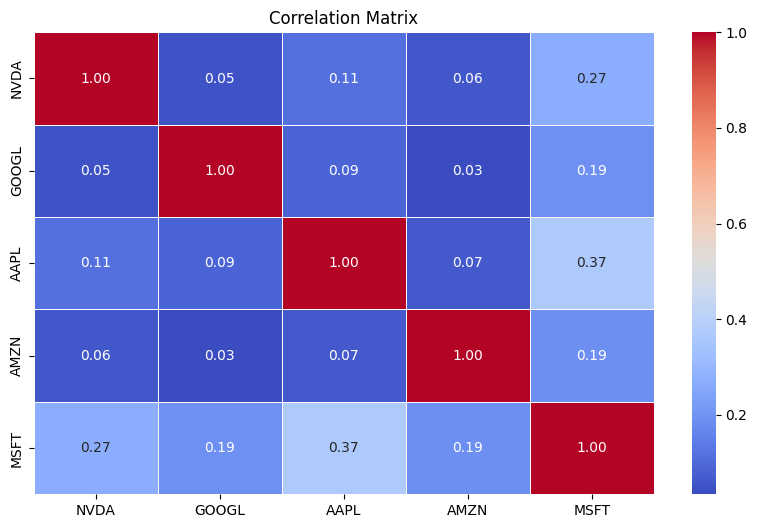

In [21]:
#plot the correlation matrix to check how the stocks are correlated

plot_correlation_matrix(df_correlation)

In [22]:
#calculate the covariance

df_covariance = df_returns.cov() * 12
print(df_covariance)

           NVDA     GOOGL      AAPL      AMZN      MSFT
NVDA   0.080489  0.004182  0.004715  0.004872  0.005083
GOOGL  0.004182  0.088912  0.003800  0.002968  0.003752
AAPL   0.004715  0.003800  0.021588  0.002829  0.003582
AMZN   0.004872  0.002968  0.002829  0.087469  0.003660
MSFT   0.005083  0.003752  0.003582  0.003660  0.004403


In [23]:
#function to plot the covariance matrix

def plot_covariance_matrix(df_covariance):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_covariance, annot=True, cmap='coolwarm',fmt=".3f", linewidths=0.5)
    plt.title('Macierz kowariancji')
    plt.show()

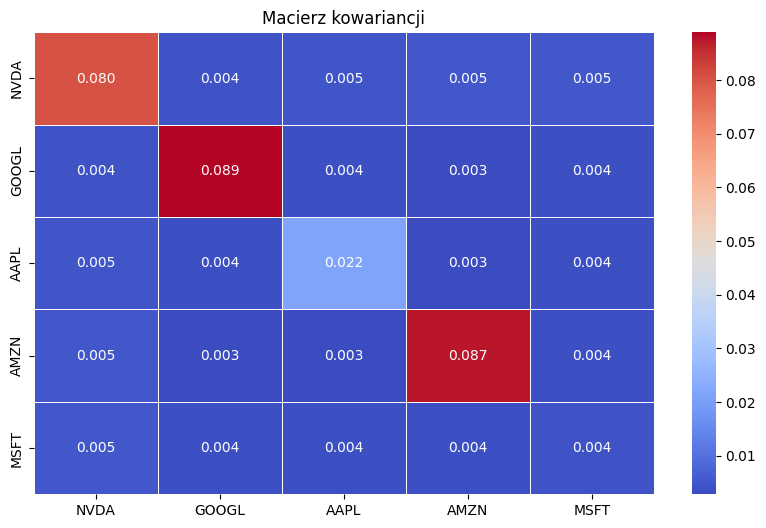

In [24]:
#plot the covariance matrix to check if the covariance is high or low

plot_covariance_matrix(df_covariance)

In [25]:
#calculate the portfolio variance

weights = np.ones(len(portfolio))/len(portfolio) 
portfolio_variance = np.dot(weights.T, np.dot(df_covariance, weights))
portfolio_std_dev = np.sqrt(portfolio_variance)
portfolio_return = np.sum(df_returns.mean() * weights) * 252
print(f'Wariancja portfela: {portfolio_variance:.8f}')


Wariancja portfela: 0.01446995


In [26]:
#calculate 10000 portfolios to plot the efficient frontier

num_portfolios = 10000
num_assets = len(portfolio)

results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)

    portfolio_return = np.sum(df_returns.mean() * weights) * 252
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(df_covariance, weights)))
    sharpe_ratio = portfolio_return / portfolio_risk

    results[0, i] = portfolio_return
    results[1, i] = portfolio_risk
    results[2, i] = sharpe_ratio

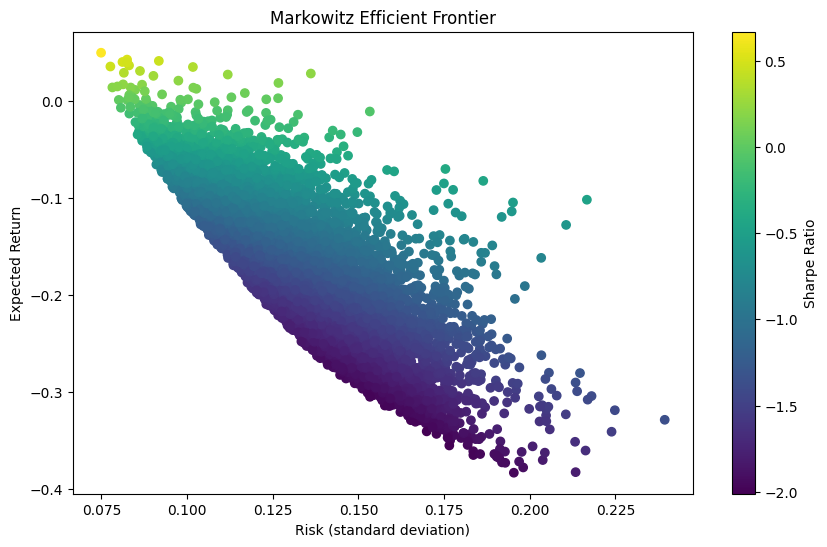

In [27]:
#plot the efficient frontier

returns, risks, sharpes = results

plt.figure(figsize=(10, 6))
plt.scatter(risks, returns, c=sharpes, cmap='viridis', marker='o')
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Risk (standard deviation)")
plt.ylabel("Expected Return")
plt.title("Markowitz Efficient Frontier")
plt.show()


In [28]:
#find the best portfolio based on the Sharpe ratio

max_sharpe_idx = np.argmax(results[2])  
best_return = results[0, max_sharpe_idx]
best_risk = results[1, max_sharpe_idx]
best_sharpe = results[2, max_sharpe_idx]

print(f"Best portfolio - return: {best_return:.2%}, risk: {best_risk:.2%}, Sharpe ratio: {best_sharpe:.2f}")


Best portfolio - return: 5.01%, risk: 7.49%, Sharpe ratio: 0.67
